In [194]:
from datetime import datetime, timedelta
import netCDF4
import numpy as np
import bisect
import math
from scipy import interpolate

# 1) Current implementation of subsetting from nc file example

In [195]:
def get_current_data_subset(nc_file, x_0, x_T, deg_around_x0_xT_box, fixed_time=None,
                            temporal_stride=1, temp_horizon_in_h=None):
    """ Function to read a subset of the nc_file current data bounded by a box spanned by the x_0 and x_T points.
    Inputs:
        nc_file                 full path to nc file
        x_0                     [lon, lat, charge, timestamp in POSIX]
        x_T                     [lon, lat] goal locations
        deg_around_x0_xT_box    float, buffer around the box in degrees
        fixed_time              if None returns time-varying currents, 
                                otherwise datetime object of the fixed time -> returns ocean current grid at or before time
                                the time of x_0 is then ignored
        temporal_stride         int, if a stride of the temporal values is used (every temporal_stride hours)
        temp_horizon            if None: all available time of the file will be provided
                                otherwise float, maximum temp_horizon to look ahead of x_0 time in hours
                                
    Outputs:
        grids_dict              dict containing x_grid, y_grid, t_grid, fixed_time_idx
        u_data                  [T, Y, X] matrix of the ocean currents in x direction in m/s
        v_data                  [T, Y, X] matrix of the ocean currents in y direction in m/s
        
    """
    
    f = netCDF4.Dataset(nc_file)

    # extract positiond & start_time for the indexing
    x_0_pos = x_0[:2]
    x_0_posix_time = x_0[3]
    x_T = x_T[:2]

    # Step 1: get the grids
    xgrid = f.variables['lon'][:]
    ygrid = f.variables['lat'][:]
    t_grid = f.variables['time'][:] # not this is in hours from HYCOM data!
    
    # this is needed because the time origin in hindcast and forecase nc files is different. Very handcrafted.
    try:
        time_origin = datetime.strptime(f.variables['time'].__dict__['time_origin'] + ' +0000',
                                        '%Y-%m-%d %H:%M:%S %z')
    except:
        time_origin = datetime.strptime(f.variables['time'].__dict__['units'] + ' +0000',
                                                 'hours since %Y-%m-%d %H:%M:%S.000 UTC %z')

    # Step 2: find the sub-setting
    # find the lat & lon sub-set bounds
    lon_bnds = [min(x_0_pos[0], x_T[0]) - deg_around_x0_xT_box, max(x_0_pos[0], x_T[0]) + deg_around_x0_xT_box]
    lat_bnds = [min(x_0_pos[1], x_T[1]) - deg_around_x0_xT_box, max(x_0_pos[1], x_T[1]) + deg_around_x0_xT_box]

    # get the respective indices from the grids
    ygrid_inds = np.where((ygrid >= lat_bnds[0]) & (ygrid <= lat_bnds[1]))[0]
    xgrid_inds = np.where((xgrid >= lon_bnds[0]) & (xgrid <= lon_bnds[1]))[0]

    # for time indexing transform to POSIX time
    abs_t_grid = [(time_origin + timedelta(hours=X)).timestamp() for X in t_grid.data]
    
    # get the idx of the value left of the demanded time (for interpolation function)
    t_start_idx = bisect.bisect_right(abs_t_grid, x_0_posix_time) - 1
    if t_start_idx == len(abs_t_grid) - 1 or t_start_idx == -1:
        raise ValueError("Requested subset time is outside of the nc4 file.")

    # get the max time if provided as input
    if temp_horizon_in_h is None:   # all data provided
        t_end_idx = len(abs_t_grid)-1
    else:
        t_end_idx = bisect.bisect_right(abs_t_grid, x_0_posix_time + temp_horizon_in_h*3600.)
        if t_end_idx == len(abs_t_grid):
            raise ValueError("nc4 file does not contain requested temporal horizon.")

    # fixed time logic if necessary
    if fixed_time is None:
        slice_for_time_dim = np.s_[t_start_idx:(t_end_idx+1):temporal_stride]
        fixed_time_idx = None
    else:
        fixed_time_idx = bisect.bisect_right(abs_t_grid, fixed_time.timestamp()) - 1
        slice_for_time_dim = np.s_[fixed_time_idx]

    # Step 2: extract data
    # raw water_u is [tdim, zdim, ydim, xdim]
    if len(f.variables['water_u'].shape) == 4:  # if there is a depth dimension in the dataset
        u_data = f.variables['water_u'][slice_for_time_dim, 0, ygrid_inds, xgrid_inds]
        v_data = f.variables['water_v'][slice_for_time_dim, 0, ygrid_inds, xgrid_inds]
    # raw water_u is [tdim, ydim, xdim]
    elif len(f.variables['water_u'].shape) == 3:  # if there is no depth dimension in the dataset
        u_data = f.variables['water_u'][slice_for_time_dim, ygrid_inds, xgrid_inds]
        v_data = f.variables['water_v'][slice_for_time_dim, ygrid_inds, xgrid_inds]
    else:
        raise ValueError("Current data in nc file has neither 3 nor 4 dimensions. Check file.")

    # create dict to output
    grids_dict = {'x_grid': xgrid[xgrid_inds], 'y_grid': ygrid[ygrid_inds],
                  't_grid': abs_t_grid[slice_for_time_dim], 'fixed_time_idx': fixed_time_idx}

    # log what data has been subsetted
    if fixed_time is None:
        print("Subsetted data from {start} to {end} in {n_steps} time steps of {time:.2f} hour(s) resolution".format(
            start=datetime.utcfromtimestamp(grids_dict['t_grid'][0]).strftime('%Y-%m-%d %H:%M:%S UTC'),
            end=datetime.utcfromtimestamp(grids_dict['t_grid'][-1]).strftime('%Y-%m-%d %H:%M:%S UTC'),
            n_steps=len(grids_dict['t_grid']), time=(grids_dict['t_grid'][1] - grids_dict['t_grid'][0])/3600.))
    else:
        print("Subsetted data to fixed time at: {time}".format(
            time=datetime.utcfromtimestamp(grids_dict['t_grid'][0]).strftime('%Y-%m-%d %H:%M:%S UTC')))

    #TODO: we replace the masked array with fill value 0 because otherwise interpolation doesn't work.
    # Though that means we cannot anymore detect if we're on land or not (need a way to do that/detect stranding)
    # not sure yet if we'll do it in the simulator or where.
    return grids_dict, u_data.filled(fill_value=0.), v_data.filled(fill_value=0.)


# 2) C3 function loading data using file-based approach

In [251]:
# def get_current_data_subset_from_c3(
#     t_interval, #temp_res_in_h,   ----> separate function
#     lat_interval, #lat_res_in_deg,
#     lon_interval, #lon_res_in_deg,
#     #depth_interval_to_avg_over
# ):

# scipy.interpolate.interp1d

""" Function to get a subset of current data via the C3 data integration.

Inputs:
    t_interval              if time-varying: [t_0, t_T] in POSIX time
                            where t_0 and t_T are the start and end timestamps respectively
                            if fixed_time:   [fixed_timestamp] in POSIX
    temp_res_in_h           which temporal resolution the time-axis should have
                            e.g. if temp_res_in_h = 1, t_grid = [t_0, t_0 + 3600s, ... t_T]
                            if temp_res_in_h = 5,      t_grid = [t_0, t_0 + 5*3600s, ... t_T]
                            if temp_res_in_h = 0.5,      t_grid = [t_0, t_0 + 1800s, ... t_T]
                            => so either averaging or interpolation needs to be done in the backend
    lat_interval            [y_lower, y_upper] in degrees
    lat_res_in_deg          which spatial resolution in y direction in degrees
                            e.g. if lat_res_in_deg = 1, y_grid = [y_lower, y_lower + 1, ... y_upper]
                             => so either averaging or interpolation needs to be done in the backend
    lon_interval            [x_lower, x_upper] in degrees
    lon_res_in_deg          which spatial resolution in x direction in degrees
                            e.g. if lon_res_in_deg = 1, x_grid = [x_lower, x_lower + 1, ... x_upper]
                             => so either averaging or interpolation needs to be done in the backend
    depth_interval_to_avg_over
                            Interval to average over the current dimension in meters
                            e.g. [0, 10] then the currents are averaged over the depth 0-10m.

Outputs:
    grids_dict              dict containing x_grid, y_grid, t_grid
    u_data                  [T, Y, X] matrix of the ocean currents in x direction in m/s
    v_data                  [T, Y, X] matrix of the ocean currents in y direction in m/s
"""

# Step 1: get required file references and data from C3 file DB
# Step 1.1: Getting time and formatting for the db query
start_date = datetime.utcfromtimestamp(t_interval[0]).strftime("%Y-%m-%d")
end_date = datetime.utcfromtimestamp(t_interval[1]).strftime("%Y-%m-%d")


# Step 1.2: Getting correct range of nc files from database
filter_string = 'start>=' + '"'+ start_date + '"' + ' && end<=' + '"' + end_date + "T23:00:00.000" + '"'
objs_list = c3.HindcastFile.fetch({'filter':filter_string, "order": "start"}).objs
if objs_list is None:
    raise ValueError("No files in the database for the selected t_interval")

# Step 1.3: extract url and start list from the query results
urls_list = [obj.file.url for obj in objs_list]
start_list = [obj.start for obj in objs_list]

# Step 2: Prepare the stacking loop by getting the x, y grids and subsetting indices in x, y 
# Note: these stay constant across files in this case where all files have same lat-lon range

# Step 2.1: open the file and get the x and y grid
f = c3.HycomUtil.nc_open(urls_list[0])
xgrid = f.variables['lon'][:].data
ygrid = f.variables['lat'][:].data

# Step 2.2: get the respective indices of the lat, lon subset from the file grids
ygrid_inds = np.where((ygrid >= lat_interval[0]) & (ygrid <= lat_interval[1]))[0]
xgrid_inds = np.where((xgrid >= lon_interval[0]) & (xgrid <= lon_interval[1]))[0]

# Step 2.3 initialze t_grid stacking variable
full_t_grid = []

# Step 3: iterate over all files in order and stack the current data and absolute t_grids
for idx in range(len(start_list)):
    # Step 3.0: load the current data file
    f = c3.HycomUtil.nc_open(urls_list[idx])
    # set the default start and end time
    start_hr, end_hr = 0, 24

    # Step 3.1: do the time-subsetting
    #Case 1: file is first -- get data from the file from the hour before or at t_0
    if idx == 0:
        start_hr = math.floor((t_interval[0] - start_list[idx].timestamp())/3600)
    #Case 2: file is last -- get data from file until or after the hour t_T
    if idx == len(start_list)-1:
        end_hr = math.ceil((t_interval[1] - start_list[idx].timestamp())/3600)+1

    # Step 3.2: extract data from the file
    u_data = f.variables['water_u'][start_hr:end_hr, 0, ygrid_inds, xgrid_inds]
    v_data = f.variables['water_v'][start_hr:end_hr, 0, ygrid_inds, xgrid_inds]
    
    # Step 3.3: stack the sub-setted abs_t_grid and current data
    full_t_grid = full_t_grid + [start_list[idx].timestamp() + i*3600 for i in range(start_hr, end_hr)]

    if idx == 0:
        full_u_data = u_data
        full_v_data = v_data
        spatial_land_mask = f.variables['water_u'][:, :, :, :].mask[0, 0, ygrid_inds, :][:,xgrid_inds]
    else:
        full_u_data = np.concatenate((full_u_data, u_data), axis=0)
        full_v_data = np.concatenate((full_v_data, v_data), axis=0)

# Step 4: create dict to output
grids_dict = {'x_grid': xgrid[xgrid_inds], 'y_grid': ygrid[ygrid_inds], 't_grid': full_t_grid}
# Step 5: # log what data has been subsetted
print("Subsetted data from {start} to {end} in {n_steps} time steps of {time:.2f} hour(s) resolution".format(
    start=datetime.utcfromtimestamp(grids_dict['t_grid'][0]).strftime('%Y-%m-%d %H:%M:%S UTC'),
    end=datetime.utcfromtimestamp(grids_dict['t_grid'][-1]).strftime('%Y-%m-%d %H:%M:%S UTC'),
    n_steps=len(grids_dict['t_grid']), time=(grids_dict['t_grid'][1] - grids_dict['t_grid'][0])/3600.))

# Step 6: return the grids_dict and the stacked data
# TODO: currently, we just do fill_value =0 but then we can't detect if we're on land. 
# We need a way to do that in the simulator, doing it via the currents could be one way.
#     return grids_dict, full_u_data.filled(fill_value=0.), full_v_data.filled(fill_value=0.)

Subsetted data from 2021-09-02 12:00:00 UTC to 2021-09-03 12:00:00 UTC in 25 time steps of 1.00 hour(s) resolution


In [267]:
spatial_land_mask.shape
print(grids_dict['x_grid'])

[-82.         -81.92004394 -81.84008788 -81.76013182 -81.68017576
 -81.6002197  -81.52026364 -81.44030758 -81.36035152 -81.28039546
 -81.2004394  -81.12048334 -81.04052728]


In [283]:
x_idx = np.where(grids_dict['x_grid']==-82)
print(bisect.bisect_left(grids_dict['x_grid'], -81.93))
y_idx = np.where(grids_dict['y_grid']==29)[0]
print(grids_dict['x_grid'].shape, grids_dict['y_grid'].shape, spatial_land_mask.shape)
spatial_land_mask[1,1]

1
(13,) (25,) (51, 26)


True

In [254]:
lon_interval = [-82,-81]
lat_interval = [28, 30]
t_interval = [1630584000.0, 1630670400.0] # that's two days 2021-09-02-12 to 2021-09-04-12

In [255]:
from scipy import interpolate

def transform(data, x, y, xnew, ynew):
    f = interpolate.interp2d(x, y, data, kind='cubic')
    return f(xnew, ynew)

def apply_lon_interpolation(res, grids_dict, u_data, v_data):
    lon_grid = grids_dict['x_grid']
    lat_grid = grids_dict['y_grid']
    new_lon_grid = np.arange(lon_grid[0], lon_grid[-1], res*0.03997803000000033)
    t = u_data.shape[0]
    new_u_data = np.array([transform(u_data[i].data, lon_grid, lat_grid, new_lon_grid, lat_grid) for i in range(t)])
    new_v_data = np.array([transform(v_data[i].data, lon_grid, lat_grid, new_lon_grid, lat_grid) for i in range(t)])
    return new_lon_grid, new_u_data, new_v_data

def apply_lat_interpolation(res, grids_dict, u_data, v_data):
    lon_grid = grids_dict['x_grid']
    lat_grid = grids_dict['y_grid']
    new_lat_grid = np.arange(lat_grid[0], lat_grid[-1], res*0.03999900817871094)
    t = u_data.shape[0]
    print(t)
    print(lon_grid.shape, lat_grid.shape)
    new_u_data = np.array([transform(u_data[i].data, lon_grid, lat_grid, lon_grid, new_lat_grid) for i in range(t)])
    new_v_data = np.array([transform(v_data[i].data, lon_grid, lat_grid, lon_grid, new_lat_grid) for i in range(t)])
    return new_lat_grid, new_u_data, new_v_data

In [256]:
def apply_interpolation(grids_dict, u_data, v_data, time_res=None, lat_res=None, lon_res=None):    
    if time_res: 
        new_t_grid, u_data, v_data = apply_time_resolution(time_res, grids_dict, u_data, v_data)
        grids_dict['t_grid'] = new_t_grid
    if lat_res:
        new_lat_grid, u_data, v_data = apply_lat_interpolation(lat_res, grids_dict, u_data, v_data)
        grids_dict['y_grid'] = new_lat_grid
    if lon_res:
        new_lon_grid, u_data, v_data = apply_lon_interpolation(lon_res, grids_dict, u_data, v_data)
        grids_dict['x_grid'] = new_lon_grid
    return grids_dict, u_data, v_data 

In [259]:
grids, u, v  = apply_interpolation(grids_dict, full_u_data, full_v_data, 2, 2, 2)

13
(26,) (51,)


In [260]:
print(full_u_data.shape)
u.shape

(25, 51, 26)


(13, 25, 13)

In [250]:
z = full_u_data[0].data
print(lon_grid.shape)
print(lat_grid.shape)
#x, y = np.meshgrid(lon_grid, lat_grid)
f = interpolate.interp2d(lon_grid, lat_grid, full_u_data[0].data, kind='cubic')
print(full_u_data[0].shape)
f(new_lon_grid, lat_grid).shape
print(lat_grid[0]-lat_grid[1], lat_grid[1]-lat_grid[2], lat_grid[2]-lat_grid[3], lat_grid[3]-lat_grid[4])

(26,)
(51,)
(51, 26)
-0.04000091552734375 -0.03999900817871094 -0.04000091552734375 -0.03999900817871094


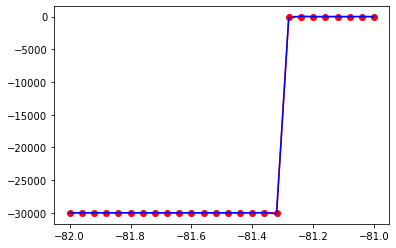

In [154]:
import matplotlib.pyplot as plt
znew = f(new_lon_grid, lat_grid)
xnew = new_lon_grid
plt.plot(lon_grid, full_u_data[0].data[-1, :], 'ro-', new_lon_grid, znew[-1, :], 'b-')

# 3) Sanity check if data directly from subsetted file and via c3 files is same

In [ ]:
# settings for directly from subsetted file and old approach
hindcast_file = 'Sanity_check_data.nc4'
x_0 = [-90.0, 24.0, 1, 1630584000.0]  # lon, lat, battery, posix_time
x_T = [-89.0, 25.0]
deg_around_x0_xT_box = 0.
fixed_time = None
temporal_stride = 1

# function callfile_
file_grids_dict, file_u_data, file_v_data = get_current_data_subset(hindcast_file,
                                                     x_0, x_T,
                                                     deg_around_x0_xT_box,
                                                     fixed_time,
                                                     temporal_stride,
                                                              temp_horizon_in_h=None)

In [ ]:
# running same query via the data pipeline using the files from the C3 database
lon_interval = [-90,-89]
lat_interval = [24, 25]
t_interval = [1630584000.0, 1630670400.0] # that's two days 2021-09-02-12 to 2021-09-04-12
t_interval = [file_grids_dict['t_grid'][0], file_grids_dict['t_grid'][-1]] # that's two days 2021-09-02-12 to 2021-09-04-12
c3_grids_dict, c3_u_data, c3_v_data = get_current_data_subset_from_c3(t_interval, lat_interval, lon_interval)

In [ ]:
# compare if they output matrices are the same (they should)
np.all(file_u_data==c3_u_data)

# 4) Time resolution function

In [189]:
def apply_time_resolution(temp_res_in_h, grids_dict, u_data, v_data):
    t_grid = np.array(grids_dict["t_grid"])
    if temp_res_in_h <= 0:
        raise ValueError("Temporal resolution must be positive")
    
    if temp_res_in_h >= 1: # Case 1: aggregation 
        indices = [i for i in range(len(t_grid)) if i % temp_res_in_h == 0]
        new_t_grid = t_grid[indices]
        new_u_data = u_data[indices]
        new_v_data = v_data[indices]
    else: #Case 2: interpolation 
        new_t_grid = np.arange(t_grid[0], t_grid[-1], temp_res_in_h*3600)
        f_u = scipy.interpolate.interp1d(t_grid, u_data, axis=0)
        f_v = scipy.interpolate.interp1d(t_grid, v_data, axis=0)
        new_u_data = f_u(new_t_grid)
        new_v_data = f_v(new_t_grid)
        
    return new_t_grid, new_u_data, new_v_data

# Sanity check on time resolution function

Case 1: aggregation. Check if the new and old data are the same at overlapping hours. 

In [ ]:
new_t_grid, new_u_data, new_v_data = apply_time_resolution(2, c3_grids_dict, c3_u_data, c3_v_data)
for i in range(len(new_t_grid)):
    print(np.all(new_u_data[i]==c3_u_data[i*2]) and np.all(new_v_data[i]==c3_v_data[i*2]))

Case 2: Interpolation. Check if the new and old data are the same at overlapping hours, and also the in between time interval's data makes sense 

In [ ]:
new_t_grid, new_u_data, new_v_data = apply_time_resolution(0.5, c3_grids_dict, c3_u_data, c3_v_data)
for i in range(c3_u_data.shape[0]-1):
    print(np.allclose(new_u_data[i*2],c3_u_data[i]) and np.allclose(new_v_data[i*2],c3_v_data[i]))
#check the data[0.5] is close to mean(data[0],data[1]), which means the interpolation makes sense 
print(np.allclose(new_u_data[1], np.mean([c3_u_data[0],c3_u_data[1]], axis=0)))